#### Importing Libraries

In [2]:
import math
import csv
import numpy as np
#from keras.models import Sequential
#from keras.layers import Dense, Dropout   #for generating nn
from copy import deepcopy as dcopy

#Tensorflow 2.0 ---> no warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

np.random.seed(12345)

# digits are from 1 to 9
D = 9
# training data
perc_train = 0.8

#### Getting data from the internet

In [3]:
# To download the data file (if needed)
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12-xpCngYpp0CIxe-sVDwBuLkAg1g96In' -O 'secretkeys_exe.csv'

--2020-03-18 15:36:45--  https://docs.google.com/uc?export=download&id=12-xpCngYpp0CIxe-sVDwBuLkAg1g96In
Resolving docs.google.com (docs.google.com)... 216.58.208.174, 2a00:1450:4002:806::200e
Connecting to docs.google.com (docs.google.com)|216.58.208.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ohiojo7qqprdjs914urkt0tcpmbs4r4/1584542175000/10574029591780364395/*/12-xpCngYpp0CIxe-sVDwBuLkAg1g96In?e=download [following]
--2020-03-18 15:36:46--  https://doc-04-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ohiojo7qqprdjs914urkt0tcpmbs4r4/1584542175000/10574029591780364395/*/12-xpCngYpp0CIxe-sVDwBuLkAg1g96In?e=download
Resolving doc-04-6c-docs.googleusercontent.com (doc-04-6c-docs.googleusercontent.com)... 216.58.206.33, 2a00:1450:4002:803::2001
Connecting to doc-04-6c-docs.googleusercontent.com (doc-04-6c-docs.google

#### Loading data

In [4]:
fname = 'secretkeys_exe.csv'
dataset = np.loadtxt(fname, delimiter=',', dtype=int)
N = len(dataset)
print(f'data: {N}')

# separating data and labels
s = dataset[:,0]
y = dataset[:,-1]

# length of a string
L = len(str(s[0]))
print(L)
LD = L*D
print('Dimension of each data sample: ',LD,'\n')

for ii in range(10):
    print(s[ii],y[ii])
    
#train test split
N_train = int(perc_train * N)
print(f'\ndata: {N}\ntrain: {N_train}')

data: 3000
7
Dimension of each data sample:  63 

4573627 0
9393629 0
9334246 0
1861971 0
5527227 1
9614284 0
5793135 0
6265761 1
7731649 1
1862956 1

data: 3000
train: 2400


#### Train Test split

In [5]:
def expand(S):
    if(len(str(S)) != L):
        print('debugging: mismatch!')
        return []
    x = [0] * LD
    p = 10**(L-1)
    j = 0
    while j<L:
        q = int(S/p)  #obtained 1st digit
        # recall that positions in python start from 0
        x[j*D+q-1] = 1
        j+=1
        S = S - q*p
        p = int(p/10)
    return x

In [6]:
# train test splitting
x_all = [None] * N
for ii in range(N):
    x_all[ii] = expand(s[ii])
    
(x_train, y_train) = (x_all[0:N_train],y[0:N_train]) 
(x_test, y_test) = (x_all[N_train:],y[N_train:]) 

print(len(x_train),len(x_test))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

2400 600


#### Augmenting Data

In [7]:
#AUGMENTATION

def augment(dataset):
    new_dataset = dcopy(dataset)
    for i in range(1,int(len(dataset[0])/9)):
        new_dataset = np.concatenate((new_dataset, np.roll(dataset,int(i*9), axis=1)), axis=0)
    return new_dataset

x_augmented = augment(x_train)
y_augmented = y_augmented = np.tile(y_train, 7)

In [24]:
#SCALING

def scale(dataset):
    mean = np.mean(dataset)
    std = np.std(dataset)
    return (dataset-mean)/std, mean, std

x_scaled, scaling_mean, scaling_std = scale(x_augmented)
y_scaled = dcopy(y_augmented) # y don't have to be scaled, just the x

# there is also this other function  --->  Scales each feature independently, you end up sending same
#                                          initial values into different ones.
#from sklearn import preprocessing

#x_scaled = preprocessing.scale(x_augmented)
#y_scaled = preprocessing.scale(y_augmented)

#### Creating the Model

In [26]:
# model definiiton
model = Sequential()
model.add(Dense(LD,input_shape=(LD,),activation='relu'))
model.add(Dense(max(10,int(LD/2)),activation='relu')) #adding layer
model.add(Dense(max(6,int(LD/4)),activation='relu')) #adding layer

#dropout procedure: with p=0.2 catch out nodes: reduces risk
  # of overfitting
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))#final layer: 1d, with sigmoid
print(model.summary())

# MODEL FOR THE SCALED DATA

# model1 definiiton
model1 = Sequential()
model1.add(Dense(LD,input_shape=(LD,),activation='relu'))
model1.add(Dense(max(10,int(LD/2)),activation='relu')) #adding layer
model1.add(Dense(max(6,int(LD/4)),activation='relu')) #adding layer

#dropout procedure: with p=0.2 catch out nodes: reduces risk
  # of overfitting
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid'))#final layer: 1d, with sigmoid

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 63)                4032      
_________________________________________________________________
dense_25 (Dense)             (None, 31)                1984      
_________________________________________________________________
dense_26 (Dense)             (None, 15)                480       
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 16        
Total params: 6,512
Trainable params: 6,512
Non-trainable params: 0
_________________________________________________________________
None


#### Training the Model

In [27]:
# optimization
model.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])

# fit
fit = model.fit(x_augmented, y_augmented,
                epochs = 80, batch_size = 20,
                validation_data = (x_test,y_test),
                shuffle = True)


Train on 16800 samples, validate on 600 samples
Epoch 1/80
16800/16800 [==============================] - 1s 58us/sample - loss: 0.4743 - accuracy: 0.7736 - val_loss: 0.4007 - val_accuracy: 0.8283
Epoch 2/80
16800/16800 [==============================] - 1s 44us/sample - loss: 0.2903 - accuracy: 0.8668 - val_loss: 0.2183 - val_accuracy: 0.9017
Epoch 3/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.1926 - accuracy: 0.9198 - val_loss: 0.1881 - val_accuracy: 0.9067
Epoch 4/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.1675 - accuracy: 0.9314 - val_loss: 0.1838 - val_accuracy: 0.9167
Epoch 5/80
16800/16800 [==============================] - 1s 44us/sample - loss: 0.1543 - accuracy: 0.9362 - val_loss: 0.1872 - val_accuracy: 0.9117
Epoch 6/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.1487 - accuracy: 0.9391 - val_loss: 0.1703 - val_accuracy: 0.9267
Epoch 7/80
16800/16800 [==============================] - 

In [28]:
# optimization
model1.compile(loss='binary_crossentropy',optimizer='adam',
              metrics=['accuracy'])

fit1 = model1.fit(x_scaled, y_scaled,
                 epochs = 80, batch_size = 20,
                validation_data = ((x_test-scaling_mean)/scaling_std,y_test),
                shuffle = True)

Train on 16800 samples, validate on 600 samples
Epoch 1/80
16800/16800 [==============================] - 1s 58us/sample - loss: 0.4637 - accuracy: 0.7760 - val_loss: 0.3652 - val_accuracy: 0.8300
Epoch 2/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.2716 - accuracy: 0.8766 - val_loss: 0.1892 - val_accuracy: 0.9150
Epoch 3/80
16800/16800 [==============================] - 1s 46us/sample - loss: 0.1851 - accuracy: 0.9221 - val_loss: 0.1673 - val_accuracy: 0.9383
Epoch 4/80
16800/16800 [==============================] - 1s 47us/sample - loss: 0.1652 - accuracy: 0.9329 - val_loss: 0.1703 - val_accuracy: 0.9250
Epoch 5/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.1556 - accuracy: 0.9350 - val_loss: 0.1602 - val_accuracy: 0.9317
Epoch 6/80
16800/16800 [==============================] - 1s 45us/sample - loss: 0.1521 - accuracy: 0.9373 - val_loss: 0.1753 - val_accuracy: 0.9250
Epoch 7/80
16800/16800 [==============================] - 

#### Showing the results

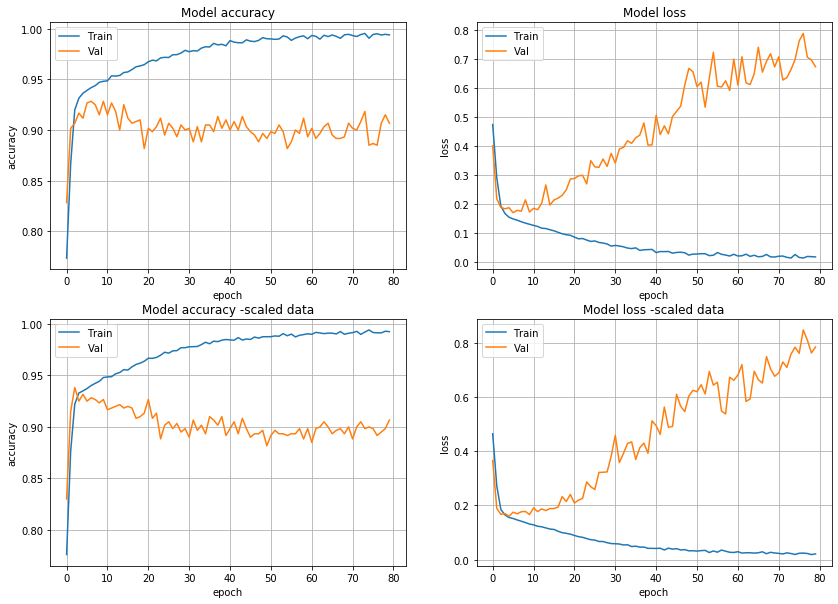

In [29]:
# plot
import matplotlib.pyplot as plt

figp, axp = plt.subplots(2,2, figsize=(14,10))
axp[0][0].set_title('Model accuracy')
axp[0][0].set_xlabel('epoch')
axp[0][0].set_ylabel('accuracy')
axp[0][0].plot(fit.history['accuracy'])
axp[0][0].plot(fit.history['val_accuracy'])
axp[0][0].legend(['Train','Val'])
axp[0][0].grid()

axp[0][1].set_title('Model loss')
axp[0][1].set_xlabel('epoch')
axp[0][1].set_ylabel('loss')
axp[0][1].plot(fit.history['loss'])
axp[0][1].plot(fit.history['val_loss'])
axp[0][1].legend(['Train','Val'])
axp[0][1].grid()

axp[1][0].set_title('Model accuracy -scaled data')
axp[1][0].set_xlabel('epoch')
axp[1][0].set_ylabel('accuracy')
axp[1][0].plot(fit1.history['accuracy'])
axp[1][0].plot(fit1.history['val_accuracy'])
axp[1][0].legend(['Train','Val'])
axp[1][0].grid()

axp[1][1].set_title('Model loss -scaled data')
axp[1][1].set_xlabel('epoch')
axp[1][1].set_ylabel('loss')
axp[1][1].plot(fit1.history['loss'])
axp[1][1].plot(fit1.history['val_loss'])
axp[1][1].legend(['Train','Val'])
axp[1][1].grid()

plt.show()

### Grid Search

In [8]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import PReLU
import matplotlib.pyplot as plt

In [9]:
def create_model(size, activation, dropout, n_hidden, optimizer):
    """
    This function creates a model given these 5 parameters:
    - size : the size of the first hidden layer, the following ones
             are decreased with a power of 2/3;
    - activation : the activation function of the hidden layers;
    - dropout : the dropout probability for every layer;
    - n_hidden : number of hidden layers;
    - optimizer : the optimizer to be used.
    """
    if activation!='prelu':
        model = Sequential()
        model.add(Dense(size,input_shape=(63,),activation=activation))
        model.add(Dropout(dropout))
        for layer in range(n_hidden-1):
            model.add(Dense(int(max(3,size**(2/3))),activation=activation))
            model.add(Dropout(dropout))
        model.add(Dense(1,activation='sigmoid'))
        
    else:
        model = Sequential()
        model.add(Dense(size,input_shape=(63,)))
        model.add(tf.keras.layers.PReLU())
        model.add(Dropout(dropout))
        for layer in range(n_hidden):
            model.add(Dense(int(max(3,size**(2/3)))))
            model.add(tf.keras.layers.PReLU())
        model.add(Dense(1,activation='sigmoid'))
        
    model.compile(loss='binary_crossentropy',optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [10]:
def random_search(params, n):
    """
    This function returns a number n of sets of parameters
    to be tried using a random search method.
    """
    param_try = []
    for i in range(n):
        param = dict()
        for key in params.keys():
            param[key] = np.random.choice(params[key])
        param_try.append(param)
    return param_try

In [11]:
# Some settings
n_epochs = 60
batch_size = 60
try_n_param_set = 2500

"""
List of hyperparameters to be optimized and the value they can take.
A brief description of each one of them:
- size : the size of the first hidden layer, the following ones
         are decreased with a power of 2/3;
- activation : the activation function of the hidden layers;
- dropout : the dropout probability for every layer;
- n_hidden : number of hidden layers;
- optimizer : the optimizer to be used.
"""
sizes = [40,65,90,150]
activations = ['sigmoid', 'elu', 'relu', 'prelu']
dropouts = [0,0.1,0.2,0.3]
optimizers = ['sgd', 'rmsprop', 'adamax', 'nadam']
n_hiddens = [1,2,3,4]
params = {'size': sizes,
          'activation': activations,
          'dropout': dropouts,
          'optimizer': optimizers,
          'n_hidden': n_hiddens}

# Randomly choosing try_n_param_set number of sets of parameters
# to be tested.
param_try = random_search(params, try_n_param_set)

# Choosing the data to use
x_train_search = x_augmented
y_train_search = y_augmented

# Performance gatherers
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

counter = 0
for param in param_try:
    counter += 1
    print('Evaluating model %i / %i' %(counter, len(param_try)))
    model = create_model(**param) # Creating the model
    # Training the model
    fit = model.fit(x_train_search, y_train_search,
                    epochs = n_epochs, batch_size = batch_size,
                    validation_data = (x_test,y_test),
                    shuffle = True,
                    verbose = False)
    
    # Storing the performances
    train_accuracies.append(fit.history['accuracy'])
    val_accuracies.append(fit.history['val_accuracy'])
    train_losses.append(fit.history['loss'])
    val_losses.append(fit.history['val_loss'])

Evaluating model 1 / 2500
Evaluating model 2 / 2500
Evaluating model 3 / 2500
Evaluating model 4 / 2500
Evaluating model 5 / 2500
Evaluating model 6 / 2500
Evaluating model 7 / 2500
Evaluating model 8 / 2500
Evaluating model 9 / 2500
Evaluating model 10 / 2500
Evaluating model 11 / 2500
Evaluating model 12 / 2500
Evaluating model 13 / 2500
Evaluating model 14 / 2500
Evaluating model 15 / 2500
Evaluating model 16 / 2500
Evaluating model 17 / 2500
Evaluating model 18 / 2500
Evaluating model 19 / 2500
Evaluating model 20 / 2500
Evaluating model 21 / 2500
Evaluating model 22 / 2500
Evaluating model 23 / 2500
Evaluating model 24 / 2500
Evaluating model 25 / 2500
Evaluating model 26 / 2500
Evaluating model 27 / 2500
Evaluating model 28 / 2500
Evaluating model 29 / 2500
Evaluating model 30 / 2500
Evaluating model 31 / 2500
Evaluating model 32 / 2500
Evaluating model 33 / 2500
Evaluating model 34 / 2500
Evaluating model 35 / 2500
Evaluating model 36 / 2500
Evaluating model 37 / 2500
Evaluating

Evaluating model 298 / 2500
Evaluating model 299 / 2500
Evaluating model 300 / 2500
Evaluating model 301 / 2500
Evaluating model 302 / 2500
Evaluating model 303 / 2500
Evaluating model 304 / 2500
Evaluating model 305 / 2500
Evaluating model 306 / 2500
Evaluating model 307 / 2500
Evaluating model 308 / 2500
Evaluating model 309 / 2500
Evaluating model 310 / 2500
Evaluating model 311 / 2500
Evaluating model 312 / 2500
Evaluating model 313 / 2500
Evaluating model 314 / 2500
Evaluating model 315 / 2500
Evaluating model 316 / 2500
Evaluating model 317 / 2500
Evaluating model 318 / 2500
Evaluating model 319 / 2500
Evaluating model 320 / 2500
Evaluating model 321 / 2500
Evaluating model 322 / 2500
Evaluating model 323 / 2500
Evaluating model 324 / 2500
Evaluating model 325 / 2500
Evaluating model 326 / 2500
Evaluating model 327 / 2500
Evaluating model 328 / 2500
Evaluating model 329 / 2500
Evaluating model 330 / 2500
Evaluating model 331 / 2500
Evaluating model 332 / 2500
Evaluating model 333

Evaluating model 591 / 2500
Evaluating model 592 / 2500
Evaluating model 593 / 2500
Evaluating model 594 / 2500
Evaluating model 595 / 2500
Evaluating model 596 / 2500
Evaluating model 597 / 2500
Evaluating model 598 / 2500
Evaluating model 599 / 2500
Evaluating model 600 / 2500
Evaluating model 601 / 2500
Evaluating model 602 / 2500
Evaluating model 603 / 2500
Evaluating model 604 / 2500
Evaluating model 605 / 2500
Evaluating model 606 / 2500
Evaluating model 607 / 2500
Evaluating model 608 / 2500
Evaluating model 609 / 2500
Evaluating model 610 / 2500
Evaluating model 611 / 2500
Evaluating model 612 / 2500
Evaluating model 613 / 2500
Evaluating model 614 / 2500
Evaluating model 615 / 2500
Evaluating model 616 / 2500
Evaluating model 617 / 2500
Evaluating model 618 / 2500
Evaluating model 619 / 2500
Evaluating model 620 / 2500
Evaluating model 621 / 2500
Evaluating model 622 / 2500
Evaluating model 623 / 2500
Evaluating model 624 / 2500
Evaluating model 625 / 2500
Evaluating model 626

Evaluating model 884 / 2500
Evaluating model 885 / 2500
Evaluating model 886 / 2500
Evaluating model 887 / 2500
Evaluating model 888 / 2500
Evaluating model 889 / 2500
Evaluating model 890 / 2500
Evaluating model 891 / 2500
Evaluating model 892 / 2500
Evaluating model 893 / 2500
Evaluating model 894 / 2500
Evaluating model 895 / 2500
Evaluating model 896 / 2500
Evaluating model 897 / 2500
Evaluating model 898 / 2500
Evaluating model 899 / 2500
Evaluating model 900 / 2500
Evaluating model 901 / 2500
Evaluating model 902 / 2500
Evaluating model 903 / 2500
Evaluating model 904 / 2500
Evaluating model 905 / 2500
Evaluating model 906 / 2500
Evaluating model 907 / 2500
Evaluating model 908 / 2500
Evaluating model 909 / 2500
Evaluating model 910 / 2500
Evaluating model 911 / 2500
Evaluating model 912 / 2500
Evaluating model 913 / 2500
Evaluating model 914 / 2500
Evaluating model 915 / 2500
Evaluating model 916 / 2500
Evaluating model 917 / 2500
Evaluating model 918 / 2500
Evaluating model 919

Evaluating model 1171 / 2500
Evaluating model 1172 / 2500
Evaluating model 1173 / 2500
Evaluating model 1174 / 2500
Evaluating model 1175 / 2500
Evaluating model 1176 / 2500
Evaluating model 1177 / 2500
Evaluating model 1178 / 2500
Evaluating model 1179 / 2500
Evaluating model 1180 / 2500
Evaluating model 1181 / 2500
Evaluating model 1182 / 2500
Evaluating model 1183 / 2500
Evaluating model 1184 / 2500
Evaluating model 1185 / 2500
Evaluating model 1186 / 2500
Evaluating model 1187 / 2500
Evaluating model 1188 / 2500
Evaluating model 1189 / 2500
Evaluating model 1190 / 2500
Evaluating model 1191 / 2500
Evaluating model 1192 / 2500
Evaluating model 1193 / 2500
Evaluating model 1194 / 2500
Evaluating model 1195 / 2500
Evaluating model 1196 / 2500
Evaluating model 1197 / 2500
Evaluating model 1198 / 2500
Evaluating model 1199 / 2500
Evaluating model 1200 / 2500
Evaluating model 1201 / 2500
Evaluating model 1202 / 2500
Evaluating model 1203 / 2500
Evaluating model 1204 / 2500
Evaluating mod

Evaluating model 1454 / 2500
Evaluating model 1455 / 2500
Evaluating model 1456 / 2500
Evaluating model 1457 / 2500
Evaluating model 1458 / 2500
Evaluating model 1459 / 2500
Evaluating model 1460 / 2500
Evaluating model 1461 / 2500
Evaluating model 1462 / 2500
Evaluating model 1463 / 2500
Evaluating model 1464 / 2500
Evaluating model 1465 / 2500
Evaluating model 1466 / 2500
Evaluating model 1467 / 2500
Evaluating model 1468 / 2500
Evaluating model 1469 / 2500
Evaluating model 1470 / 2500
Evaluating model 1471 / 2500
Evaluating model 1472 / 2500
Evaluating model 1473 / 2500
Evaluating model 1474 / 2500
Evaluating model 1475 / 2500
Evaluating model 1476 / 2500
Evaluating model 1477 / 2500
Evaluating model 1478 / 2500
Evaluating model 1479 / 2500
Evaluating model 1480 / 2500
Evaluating model 1481 / 2500
Evaluating model 1482 / 2500
Evaluating model 1483 / 2500
Evaluating model 1484 / 2500
Evaluating model 1485 / 2500
Evaluating model 1486 / 2500
Evaluating model 1487 / 2500
Evaluating mod

Evaluating model 1737 / 2500
Evaluating model 1738 / 2500
Evaluating model 1739 / 2500
Evaluating model 1740 / 2500
Evaluating model 1741 / 2500
Evaluating model 1742 / 2500
Evaluating model 1743 / 2500
Evaluating model 1744 / 2500
Evaluating model 1745 / 2500
Evaluating model 1746 / 2500
Evaluating model 1747 / 2500
Evaluating model 1748 / 2500
Evaluating model 1749 / 2500
Evaluating model 1750 / 2500
Evaluating model 1751 / 2500
Evaluating model 1752 / 2500
Evaluating model 1753 / 2500
Evaluating model 1754 / 2500
Evaluating model 1755 / 2500
Evaluating model 1756 / 2500
Evaluating model 1757 / 2500
Evaluating model 1758 / 2500
Evaluating model 1759 / 2500
Evaluating model 1760 / 2500
Evaluating model 1761 / 2500
Evaluating model 1762 / 2500
Evaluating model 1763 / 2500
Evaluating model 1764 / 2500
Evaluating model 1765 / 2500
Evaluating model 1766 / 2500
Evaluating model 1767 / 2500
Evaluating model 1768 / 2500
Evaluating model 1769 / 2500
Evaluating model 1770 / 2500
Evaluating mod

Evaluating model 2020 / 2500
Evaluating model 2021 / 2500
Evaluating model 2022 / 2500
Evaluating model 2023 / 2500
Evaluating model 2024 / 2500
Evaluating model 2025 / 2500
Evaluating model 2026 / 2500
Evaluating model 2027 / 2500
Evaluating model 2028 / 2500
Evaluating model 2029 / 2500
Evaluating model 2030 / 2500
Evaluating model 2031 / 2500
Evaluating model 2032 / 2500
Evaluating model 2033 / 2500
Evaluating model 2034 / 2500
Evaluating model 2035 / 2500
Evaluating model 2036 / 2500
Evaluating model 2037 / 2500
Evaluating model 2038 / 2500
Evaluating model 2039 / 2500
Evaluating model 2040 / 2500
Evaluating model 2041 / 2500
Evaluating model 2042 / 2500
Evaluating model 2043 / 2500
Evaluating model 2044 / 2500
Evaluating model 2045 / 2500
Evaluating model 2046 / 2500
Evaluating model 2047 / 2500
Evaluating model 2048 / 2500
Evaluating model 2049 / 2500
Evaluating model 2050 / 2500
Evaluating model 2051 / 2500
Evaluating model 2052 / 2500
Evaluating model 2053 / 2500
Evaluating mod

Evaluating model 2303 / 2500
Evaluating model 2304 / 2500
Evaluating model 2305 / 2500
Evaluating model 2306 / 2500
Evaluating model 2307 / 2500
Evaluating model 2308 / 2500
Evaluating model 2309 / 2500
Evaluating model 2310 / 2500
Evaluating model 2311 / 2500
Evaluating model 2312 / 2500
Evaluating model 2313 / 2500
Evaluating model 2314 / 2500
Evaluating model 2315 / 2500
Evaluating model 2316 / 2500
Evaluating model 2317 / 2500
Evaluating model 2318 / 2500
Evaluating model 2319 / 2500
Evaluating model 2320 / 2500
Evaluating model 2321 / 2500
Evaluating model 2322 / 2500
Evaluating model 2323 / 2500
Evaluating model 2324 / 2500
Evaluating model 2325 / 2500
Evaluating model 2326 / 2500
Evaluating model 2327 / 2500
Evaluating model 2328 / 2500
Evaluating model 2329 / 2500
Evaluating model 2330 / 2500
Evaluating model 2331 / 2500
Evaluating model 2332 / 2500
Evaluating model 2333 / 2500
Evaluating model 2334 / 2500
Evaluating model 2335 / 2500
Evaluating model 2336 / 2500
Evaluating mod

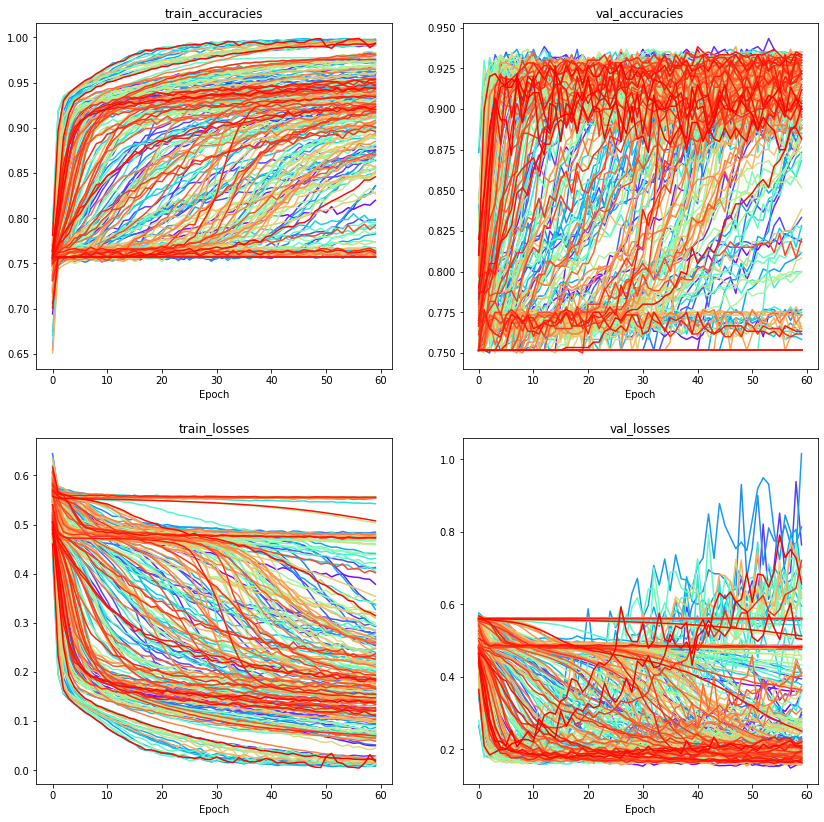

In [82]:
"""
THIS CELL IS OPTIMIZED TO SHOW JUST A SMALL NUMBER OF PERAMETERS SETS TRIED.
FOR A HIGH NUMBER OF SETS TRIED THE RESULT IS NOT WELL SHOWN (FOR A VERY HIGH
NUMBER IT MAY AS WELL CRASH).
"""

plots = [train_accuracies, val_accuracies, train_losses, val_losses]
titles = ['train_accuracies', 'val_accuracies', 'train_losses', 'val_losses']

fig, axs = plt.subplots(2,2, figsize=(14,14))
colors = plt.cm.rainbow(np.linspace(0,1,len(plots[0])))

# Plotting the performances for each set of parameters
for i in range(len(plots)):
    ax = axs[int((i-i%2)/2), i%2]
    for j in range(len(plots[i])):
        ax.plot(np.arange(n_epochs), plots[i][j], color = colors[j], label=j)
    ax.set_title(titles[i])
    ax.set_xlabel('Epoch')
    ax.legend()
    
# Linking the legend's numbers of the plots to the set of parameters
for i in range(len(param_try)):
    print('Label %i:' %i)
    for key in param_try[i].keys():
        if isinstance(param_try[i][key], str):
            print('\t%s: %s' %(key, param_try[i][key]))
        elif isinstance(param_try[i][key], int):
            print('\t%s: %i' %(key, param_try[i][key]))
        else:
            print('\t%s: %.1f' %(key, param_try[i][key]))
    print('')

Frequency of the parameters in 'size':
	40 : 620
	65 : 635
	90 : 607
	150 : 638
Frequency of the parameters in 'activation':
	elu : 647
	prelu : 651
	relu : 627
	sigmoid : 575
Frequency of the parameters in 'dropout':
	0.0 : 626
	0.1 : 607
	0.2 : 648
	0.3 : 619
Frequency of the parameters in 'optimizer':
	adamax : 646
	nadam : 629
	rmsprop : 636
	sgd : 589
Frequency of the parameters in 'n_hidden':
	1 : 628
	2 : 628
	3 : 619
	4 : 625


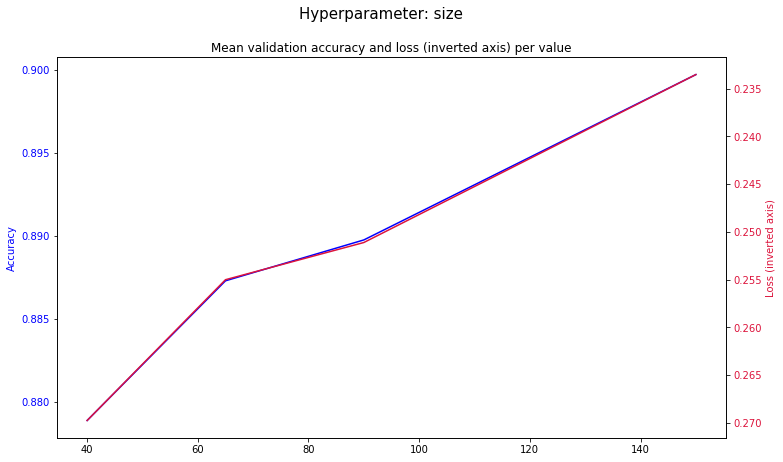

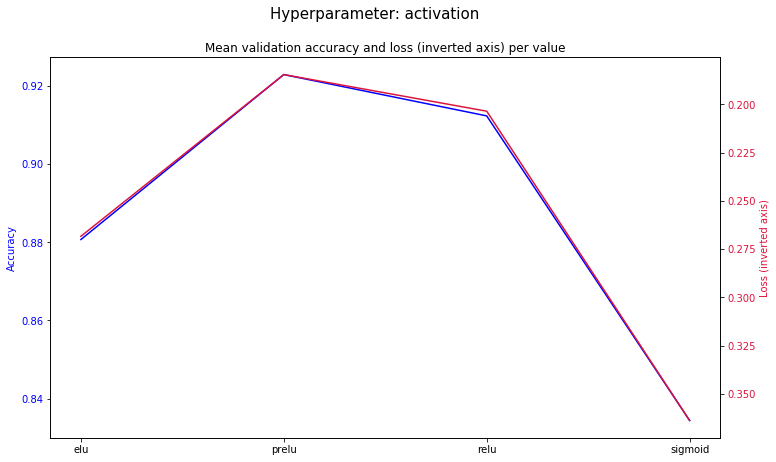

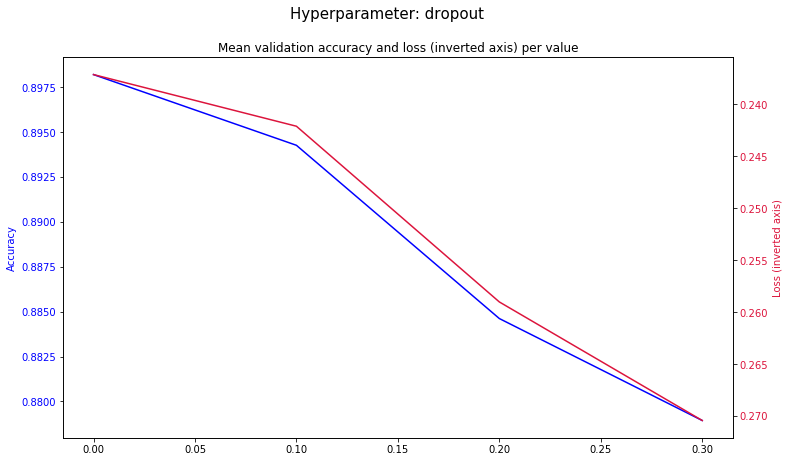

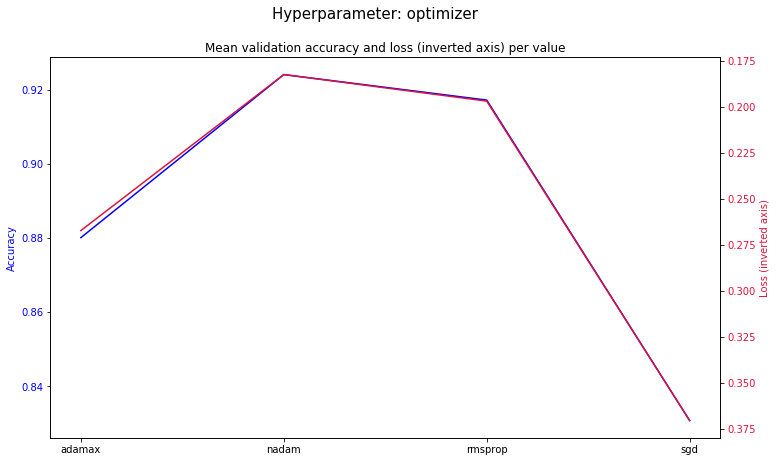

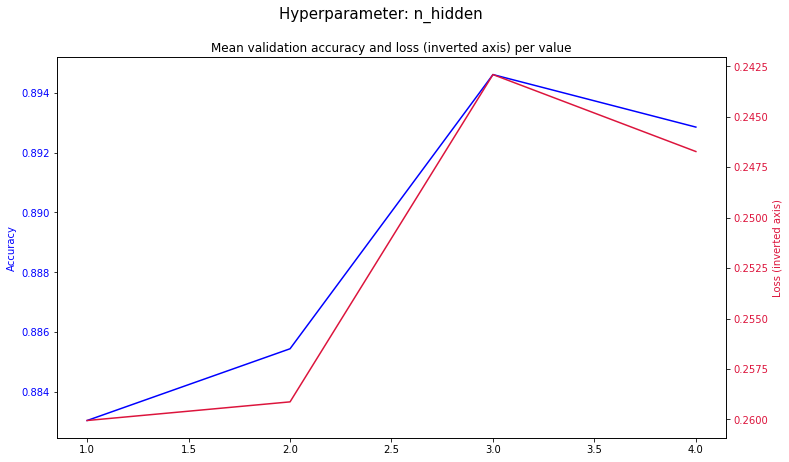

In [12]:
"""
This cell is used to find the optimal value for each parameter.
For each hyperparameter:
- it is printed the frequency of each value it took;
- it is plotted the average maximum accuracy each value reached;
- it is plotted the average minimum loss each value reached.
"""

for key in param_try[0].keys():
    values, counts = np.unique([param_set[key] for param_set in param_try], return_counts=True)
    mean_value_acc = []
    mean_value_loss = []
    for value in values:
        mean_value_acc.append(np.mean([np.max(val_accuracies[i]) for i in range(len(val_accuracies)) if param_try[i][key]==value]))
        mean_value_loss.append(np.mean([np.min(val_losses[i]) for i in range(len(val_losses)) if param_try[i][key]==value]))
    
    fig, axs = plt.subplots(1,1,figsize=(12,7))
    fig.suptitle('Hyperparameter: '+key, size=15)
    
    ax0 = axs
    color0 = 'b'
    ax0.plot(values, mean_value_acc, color=color0)
    ax0.set_title('Mean validation accuracy and loss (inverted axis) per value')
    ax0.tick_params(axis='y', labelcolor=color0)
    ax0.set_ylabel('Accuracy', color=color0)
    
    ax1 = ax0.twinx()
    color1 = 'crimson'
    ax1.plot(values, mean_value_loss, color=color1)
    plt.gca().invert_yaxis()
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.set_ylabel('Loss (inverted axis)', color=color1)
    
    print("Frequency of the parameters in '%s':" %(key))
    for value, count in zip(values, counts):
        print('\t%s : %i' %(str(value), count))

The maximum accuracy reached is

In [13]:
np.max(val_accuracies)

0.94166666

Let's see what the best architectures have in common

In [52]:
par_best = np.where(np.asarray(val_accuracies)>0.939)[0]

best_sets = []
for n in np.unique(par_best):
    best_sets.append(param_try[n])

Printing the frequencies of the values

In [59]:
print('Sizes')
for size_unique in sizes:
    print('\t%s : %i' %(str(size_unique),len([set_ for set_ in best_sets if set_['size']==size_unique])))
print('\nActivation')
for activ in activations:
    print('\t%s : %i' %(str(activ),len([set_ for set_ in best_sets if set_['activation']==activ])))
print('\nDropout')
for drop in dropouts:
    print('\t%s : %i' %(str(drop),len([set_ for set_ in best_sets if set_['dropout']==drop])))
print('\nOptimizer')
for optim in optimizers:
    print('\t%s : %i' %(str(optim),len([set_ for set_ in best_sets if set_['optimizer']==optim])))
print('\nN_hidden')
for n_hid in n_hiddens:
    print('\t%s : %i' %(str(n_hid),len([set_ for set_ in best_sets if set_['n_hidden']==n_hid])))

Sizes
	40 : 0
	65 : 4
	90 : 8
	150 : 2

Activation
	sigmoid : 0
	elu : 4
	relu : 2
	prelu : 8

Dropout
	0 : 2
	0.1 : 3
	0.2 : 3
	0.3 : 6

Optimizer
	sgd : 0
	rmsprop : 9
	adamax : 1
	nadam : 4

N_hidden
	1 : 1
	2 : 3
	3 : 3
	4 : 7


And printing the full architectures

In [54]:
for size_unique in sizes:
    for activ in activations:
        for drop in dropouts:
            for optim in optimizers:
                for n_hid in n_hiddens:
                    for set_ in best_sets:
                        if set_['size']==size_unique and set_['activation']==activ and set_['dropout']==drop \
                           and set_['optimizer']==optim and set_['n_hidden']==n_hid:
                            print(set_)

{'size': 65, 'activation': 'elu', 'dropout': 0.0, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 65, 'activation': 'prelu', 'dropout': 0.1, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 65, 'activation': 'prelu', 'dropout': 0.2, 'optimizer': 'rmsprop', 'n_hidden': 2}
{'size': 65, 'activation': 'prelu', 'dropout': 0.3, 'optimizer': 'adamax', 'n_hidden': 1}
{'size': 90, 'activation': 'elu', 'dropout': 0.1, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 90, 'activation': 'elu', 'dropout': 0.1, 'optimizer': 'nadam', 'n_hidden': 3}
{'size': 90, 'activation': 'relu', 'dropout': 0.2, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 90, 'activation': 'relu', 'dropout': 0.3, 'optimizer': 'rmsprop', 'n_hidden': 3}
{'size': 90, 'activation': 'prelu', 'dropout': 0.2, 'optimizer': 'nadam', 'n_hidden': 2}
{'size': 90, 'activation': 'prelu', 'dropout': 0.3, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 90, 'activation': 'prelu', 'dropout': 0.3, 'optimizer': 'rmsprop', 'n_hidden': 4}
{'size': 90,

Although from the graphs regarding all the architectures it might seem that the best one is:
- size = 150 (and maybe more)
- activation = prelu
- dropout = 0
- optimizer = nadam
- hidden layers = 3

From an analysis of just the best architectures it seems that the best architecture is:
- size = 90
- activation = prelu
- dropout = 0.3
- optimizer = rmsprop
- hidden layers = 4

We are going to take this as our final model.

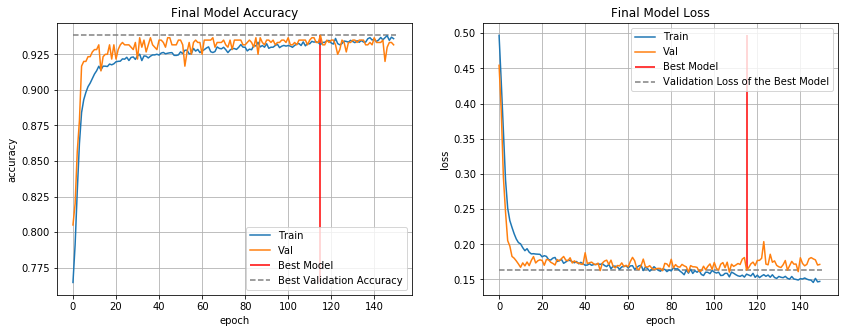

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

final_model = create_model(size = 90,
                           activation = 'prelu',
                           dropout = 0.3,
                           optimizer = 'rmsprop',
                           n_hidden = 4)

# This callback is implemented in order to restore the best model once the training has ended.
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   verbose = 0,
                   restore_best_weights = True,
                   patience = 150)

final_fit = final_model.fit(x_train_search, y_train_search,
                            epochs = 150, batch_size = 50,
                            validation_data = (x_test,y_test),
                            shuffle = True,
                            verbose = False)

best_epoch = np.where(final_fit.history['val_accuracy']==np.max(final_fit.history['val_accuracy']))[0][0]

fig, axs = plt.subplots(1,2,figsize=(14,5))

ax0 = axs[0]
ax0.plot(final_fit.history['accuracy'])
ax0.plot(final_fit.history['val_accuracy'])
ax0.vlines(best_epoch,
           np.min(np.concatenate((final_fit.history['accuracy'], final_fit.history['val_accuracy']))),
           final_fit.history['val_accuracy'][best_epoch], color='red')
ax0.hlines(final_fit.history['val_accuracy'][best_epoch], 0, 150, color='gray', linestyle='--')
ax0.set_title('Final Model Accuracy')
ax0.grid()
ax0.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(['Train','Val', 'Best Model', 'Best Validation Accuracy'])

ax1 = axs[1]
ax1.plot(final_fit.history['loss'])
ax1.plot(final_fit.history['val_loss'])
ax1.vlines(best_epoch,
           np.max(np.concatenate((final_fit.history['loss'], final_fit.history['val_loss']))),
           final_fit.history['val_loss'][best_epoch], color='red')
ax1.hlines(final_fit.history['val_loss'][best_epoch], 0, 150, color='gray', linestyle='--')
ax1.set_title('Final Model Loss')
ax1.grid()
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['Train','Val', 'Best Model', 'Validation Loss of the Best Model'])

plt.show()

Reaching the validation accuracy of

In [94]:
np.max(final_fit.history['val_accuracy'])

0.93833333